The next step of this quantitative exercise is the research and the study of the outliers. We decided to find the outliers through SPOT algorithm, so after having imported the common libraries, we imported the spot class. In our dataset the indipendent variable is the timestamp in which the temperature is measured. The value of the temperature is our dependent variable because it changes over time. Other two dependent variables are the lower and the upper thresholds. They depend not only on the time, but also on the previous values of the temperature. Our expectation in this part of the analysis is to find some outliers that are caused by sudden increments or decrements of the temperature.

In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib as mpl
import tqdm as tqdm

In [2]:
import matplotlib.pyplot as plt
from model import spot

# Temp

After having loaded the original dataset, we splitted the timestamp column in date and time in order to have the possibility of creating intervals based on the date. Due to the fact that the 1st January 2014 is in the middle of the dataset, we decided to split the data around this date. The data before the 1st January 2014 are used as initial batch, while the data after are used as streaming data.

In [3]:
f = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/ambient_temperature_system_failure.csv'
P = pd.read_csv(f)

P[['date', 'time']] = P['timestamp'].str.split(' ', 1, expand=True)

P['date'] = pd.to_datetime(P['date'])
# stream
u_data = (P['date'] >= '2014-01-01')# & (P['date'] < '2014-05-21')
data = P['value'][u_data].values

# initial batch
u_init_data = (P['date'] < '2014-01-01')
init_data = P['value'][u_init_data].values

We set the parameters, initialize the SPOT algorithm and run it. The results are shown in a temporal graph, in which we can see the lower and the upper thresholds in orange, the time series data in blue and the outliers as red points.

Initial threshold : {'up': 3.1433230590000534, 'down': -2.488465275999957}
Number of peaks : {'up': 78, 'down': 78}
Grimshaw maximum log-likelihood estimation ... [done]
	          Parameters               Upper               Lower
	------------------------------------------------------------
	                   γ                0.00                0.00
	                   σ                0.58                0.50
	          likelihood               35.11               23.49
	    Extreme quantile                7.52               -6.26
	------------------------------------------------------------


100%|█████████████████████████████████████| 3326/3326 [00:08<00:00, 399.60it/s]


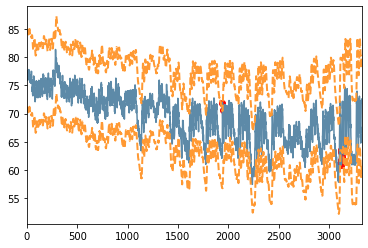

In [4]:
q = 1e-5 			# risk parameter
d = 10				# depth
s = spot.bidSPOT(q,d) 	# bidSPOT object
s.fit(init_data,data) 	# data import
s.initialize() 			# initialization step
results = s.run() 	# run
s.plot(results) 		   # plot

We are intersted only in the data that had been streamed and in particular in the outliers that has been found. So we select only the streamed data and we describe them. We also compute the mean of the thresholds and of the time series.

In [5]:
df = P[u_data]
df.describe()

,value
count,3326.000000
mean,69.441346
std,4.262653
min,57.458406
25%,66.241963
50%,70.016692
75%,72.686031
max,81.376188


In [6]:
from statistics import mean
print("mean of lower threshold : "+ str(mean(results['lower_thresholds'])))
print("mean of upper threshold : "+ str(mean(df['value'])))
print("mean of upper threshold : "+ str(mean(results['upper_thresholds'])))

mean of lower threshold : 63.24212046098561
mean of upper threshold : 69.44134633176488
mean of upper threshold : 77.64891703272487


After that, we take only the outliers and we visualize and describe them.

In [7]:
out = df.iloc[results['alarms']]
display(out)

,timestamp,value,date,time
5883,2014-03-24 19:00:00,71.943363,2014-03-24,19:00:00
5884,2014-03-24 20:00:00,70.715643,2014-03-24,20:00:00
7057,2014-05-19 22:00:00,63.165813,2014-05-19,22:00:00
7058,2014-05-19 23:00:00,63.475736,2014-05-19,23:00:00
7059,2014-05-20 00:00:00,63.468952,2014-05-20,00:00:00
7060,2014-05-20 01:00:00,61.429207,2014-05-20,01:00:00
7061,2014-05-20 02:00:00,61.677083,2014-05-20,02:00:00
7062,2014-05-20 03:00:00,61.786936,2014-05-20,03:00:00
7063,2014-05-20 04:00:00,60.885550,2014-05-20,04:00:00
7064,2014-05-20 05:00:00,61.499938,2014-05-20,05:00:00


In [8]:
out.describe()

,value
count,15.000000
mean,63.410162
std,3.345069
min,60.885550
25%,61.485389
50%,62.306267
75%,63.434908
max,71.943363


We are interested only in outliers, so we create a column in the dataframe that is equal to 1 if the row represents an outlier, 0 otherwise.

In [9]:
df['outlier'] = 0
for a in results['alarms']:
    df['outlier'].iloc[a] = 1
display(df[df['outlier']==1])

C:\Users\Matteo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Matteo\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Matteo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/use

,timestamp,value,date,time,outlier
5883,2014-03-24 19:00:00,71.943363,2014-03-24,19:00:00,1
5884,2014-03-24 20:00:00,70.715643,2014-03-24,20:00:00,1
7057,2014-05-19 22:00:00,63.165813,2014-05-19,22:00:00,1
7058,2014-05-19 23:00:00,63.475736,2014-05-19,23:00:00,1
7059,2014-05-20 00:00:00,63.468952,2014-05-20,00:00:00,1
7060,2014-05-20 01:00:00,61.429207,2014-05-20,01:00:00,1
7061,2014-05-20 02:00:00,61.677083,2014-05-20,02:00:00,1
7062,2014-05-20 03:00:00,61.786936,2014-05-20,03:00:00,1
7063,2014-05-20 04:00:00,60.885550,2014-05-20,04:00:00,1
7064,2014-05-20 05:00:00,61.499938,2014-05-20,05:00:00,1


In order to better visualize the outliers, we do not show anymore the thresolds so that it is possible to focus our attention on the red points

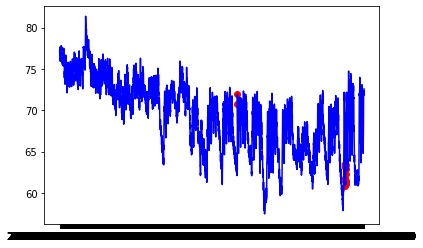

In [10]:
fig, ax = plt.subplots()

a = df.loc[df['outlier'] == 1, ['timestamp', 'value']] #anomaly

ax.plot(df['timestamp'], df['value'], color='blue')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()

As we have seen when we have shown the oulier rows, most of the outliers happened on 19th and 20th May 2014, so now a focus on that week is shown. During these days, the temperature is decread rapidly, overcoming the lower threshold, and so they resulted as outliers. Our initial expectation has been satisfied.

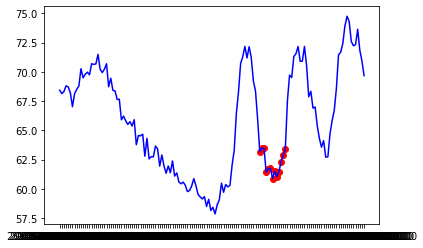

In [11]:
fig, ax = plt.subplots()

df2 = df[(df['date'] >= '2014-05-16') & (df['date']<'2014-05-22')]

a = df2.loc[df2['outlier'] == 1, ['timestamp', 'value']] #anomaly

ax.plot(df2['timestamp'], df2['value'], color='blue')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()

Finally, we want to visualize the frequence of outliers based on the value of the temperature.

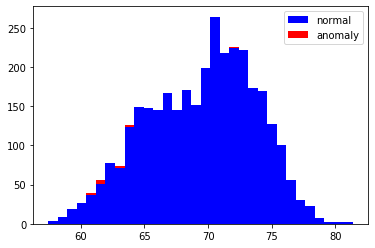

In [12]:
a = df.loc[df['outlier'] == 0, 'value']
b = df.loc[df['outlier'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

# aws

In [ ]:
f = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/ec2_request_latency_system_failure.csv'

P = pd.read_csv(f)

P[['date', 'time']] = P['timestamp'].str.split(' ', 1, expand=True)

P['date'] = pd.to_datetime(P['date'])
# stream
u_data = (P['date'] >= '2014-03-14')# & (P['date'] < '2014-05-21')
data = P['value'][u_data].values

# initial batch
u_init_data = (P['date'] < '2014-03-14')
init_data = P['value'][u_init_data].values

q = 1e-5 			# risk parameter
d = 10				# depth
s = spot.bidSPOT(q,d) 	# bidSPOT object
s.fit(init_data,data) 	# data import
s.initialize() 			# initialization step
results = s.run() 	# run
s.plot(results) 		   # plot

In [ ]:
df = P[u_data]
df.describe()

In [ ]:
from statistics import mean
print("mean of lower threshold : "+ str(mean(results['lower_thresholds'])))
print("mean of upper threshold : "+ str(mean(df['value'])))
print("mean of upper threshold : "+ str(mean(results['upper_thresholds'])))

In [ ]:
df['outlier'] = np.zeros(df.shape[0])
for a in results['alarms']:
  df['outlier'].iloc[a] = 1
display(df[df['outlier']==1])

In [ ]:
fig, ax = plt.subplots()

a = df.loc[df['outlier'] == 1, ['timestamp', 'value']] #anomaly

ax.plot(df['timestamp'], df['value'], color='blue')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()

In [ ]:
fig, ax = plt.subplots()

df2 = df[(df['date'] == '2014-03-21')]

a = df2.loc[df2['outlier'] == 1, ['timestamp', 'value']] #anomaly

ax.plot(df2['timestamp'], df2['value'], color='blue')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()

In [ ]:
a = df.loc[df['outlier'] == 0, 'value']
b = df.loc[df['outlier'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

# CPU

In [ ]:
f = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/cpu_utilization_asg_misconfiguration.csv'

P = pd.read_csv(f)

P[['date', 'time']] = P['timestamp'].str.split(' ', 1, expand=True)

P['date'] = pd.to_datetime(P['date'])
# stream
u_data = (P['date'] >= '2014-05-15')# & (P['date'] < '2014-05-21')
data = P['value'][u_data].values

# initial batch
u_init_data = (P['date'] < '2014-05-15')
init_data = P['value'][u_init_data].values

q = 1e-5 			# risk parameter
d = 10				# depth
s = spot.bidSPOT(q,d) 	# bidSPOT object
s.fit(init_data,data) 	# data import
s.initialize() 			# initialization step
results = s.run() 	# run
s.plot(results) 		   # plot

In [ ]:
df = P[u_data]
df.describe()

In [ ]:
from statistics import mean
print("mean of lower threshold : "+ str(mean(results['lower_thresholds'])))
print("mean of upper threshold : "+ str(mean(df['value'])))
print("mean of upper threshold : "+ str(mean(results['upper_thresholds'])))

In [ ]:
df['outlier'] = np.zeros(df.shape[0])
for a in results['alarms']:
  df['outlier'].iloc[a] = 1
display(df[df['outlier']==1])

In [ ]:
fig, ax = plt.subplots()

a = df.loc[df['outlier'] == 1, ['timestamp', 'value']] #anomaly

ax.plot(df['timestamp'], df['value'], color='blue')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()


In [ ]:
fig, ax = plt.subplots()

df2 = df[(df['date'] >= '2014-06-10') & (df['date'] <= '2014-06-12')]

a = df2.loc[df2['outlier'] == 1, ['timestamp', 'value']] #anomaly

ax.plot(df2['timestamp'], df2['value'], color='blue')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()

In [ ]:
a = df.loc[df['outlier'] == 0, 'value']
b = df.loc[df['outlier'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()